In [1]:
# 导入包
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data.dataloader import DataLoader

In [2]:
# 设置transforms
transform = transforms.Compose([
    transforms.ToTensor(), # numpy -> Tensor
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) # 归一化，范围[-1, 1]
])

In [3]:
# 下载数据集
# 训练集
trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
# 测试集
testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 批量读取数据
Batch_Size = 256

train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### 查看数据（格式，大小，形状）

In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RG

(50000, 32, 32, 3)

In [8]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


automobile  ship  deer   cat  frog  frog  bird automobile airplane   dog  frog truck horse horse truck  frog  frog  ship  ship  bird   cat  frog airplane   dog   dog  bird horse   cat   cat truck  deer  ship


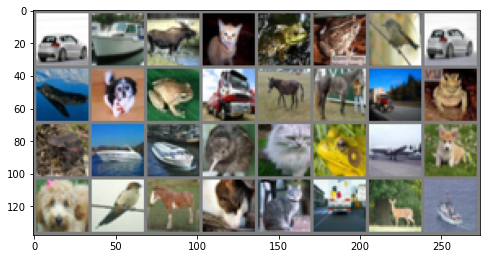

In [9]:
# 可视化显示
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))#torch.Tensor 与numpy.ndarray的转换
    plt.imshow(img)

im,label = iter(train_loader).next()    
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))
# 输出图片对应的标签
print(' '.join('%5s' % classes[label[i]] for i in range(32)))

In [10]:
#使用gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### 定义网络模型

In [11]:
# 定义网络模型

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [12]:
# 创建模型
model = Net().to(device)

In [13]:
from torchsummary import summary

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
           Dropout-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
      BatchNorm2d-13            [-1, 128, 8, 8]             256
          Dropout-14            [-1, 12

In [14]:
print(model)

Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [15]:
# 定义优化器和损失函数
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 交叉式损失函数

optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0005) # 优化器

In [16]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.
    running_loss = 0.0
    running_corrects = 0.0
    test_running_loss = 0.0
    test_running_corrects = 0.0

    for inputs, labels in train_loader:
        model.train()
        inputs = inputs.to(device) # input to device as our model is running in mentioned device.
        labels = labels.to(device)
        outputs = model(inputs) # every batch of 100 images are put as an input.
        loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 

        optimizer.zero_grad() #setting the initial gradient to 0
        loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
        
    if test_loader is not None:
        model.eval()
        with torch.no_grad(): # we do not need gradient for test
            for test_inputs, test_labels in test_loader:
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)
                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)

                _, test_preds = torch.max(test_outputs, 1)
                test_running_loss += test_loss.item()
                test_running_corrects += torch.sum(test_preds == test_labels.data)
      
    epoch_loss = running_loss/len(train_loader.dataset) # loss per epoch
    epoch_acc = running_corrects.float()/ len(train_loader.dataset) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)
    
    test_epoch_loss = test_running_loss/len(test_loader.dataset)
    test_epoch_acc = test_running_corrects.float()/ len(test_loader.dataset)
    test_running_loss_history.append(test_epoch_loss)
    test_running_corrects_history.append(test_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('testing loss: {:.4f}, testing acc {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch : 1
training loss: 0.0049, acc 0.5513 
testing loss: 0.0038, testing acc 0.6567 
epoch : 2
training loss: 0.0031, acc 0.7188 
testing loss: 0.0028, testing acc 0.7570 
epoch : 3
training loss: 0.0025, acc 0.7774 
testing loss: 0.0025, testing acc 0.7879 
epoch : 4
training loss: 0.0022, acc 0.8096 
testing loss: 0.0024, testing acc 0.7830 
epoch : 5
training loss: 0.0019, acc 0.8305 
testing loss: 0.0023, testing acc 0.8050 
epoch : 6
training loss: 0.0017, acc 0.8461 
testing loss: 0.0022, testing acc 0.8170 
epoch : 7
training loss: 0.0016, acc 0.8569 
testing loss: 0.0020, testing acc 0.8321 
epoch : 8
training loss: 0.0015, acc 0.8712 
testing loss: 0.0019, testing acc 0.8411 
epoch : 9
training loss: 0.0014, acc 0.8802 
testing loss: 0.0019, testing acc 0.8413 
epoch : 10
training loss: 0.0013, acc 0.8871 
testing loss: 0.0017, testing acc 0.8532 
epoch : 11
training loss: 0.0012, acc 0.8929 
testing loss: 0.0019, testing acc 0.8466 
epoch : 12
training loss: 0.0011, acc 0.8

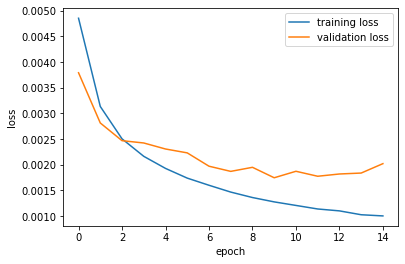

In [17]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(running_loss_history, label='training loss')
plt.plot(test_running_loss_history, label='validation loss')
plt.legend()

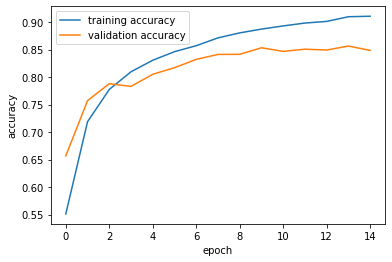

In [18]:
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(test_running_corrects_history, label='validation accuracy')
plt.legend()

In [19]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in test_loader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    model.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = model(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 84.00 %


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane is: 90.4 %
Accuracy for class automobile is: 94.2 %
Accuracy for class bird  is: 72.2 %
Accuracy for class cat   is: 54.4 %
Accuracy for class deer  is: 80.6 %
Accuracy for class dog   is: 91.0 %
Accuracy for class frog  is: 90.6 %
Accuracy for class horse is: 91.0 %
Accuracy for class ship  is: 92.9 %
Accuracy for class truck is: 91.2 %


Accuracy Rate = 85.15625%


<Figure size 1800x288 with 0 Axes>

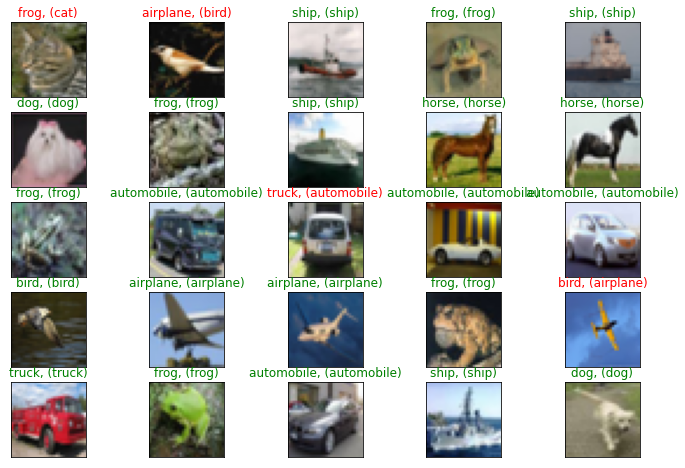

In [32]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = model(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(12,8))
for idx in np.arange(25):    
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

In [33]:
PATH = './cifar_net.pth'

torch.save(model.state_dict(), PATH)